## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [53]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN

In [54]:
help(np.max)

Help on function amax in module numpy.core.fromnumeric:

amax(a, axis=None, out=None, keepdims=<class 'numpy._globals._NoValue'>)
    Return the maximum of an array or maximum along an axis.
    
    Parameters
    ----------
    a : array_like
        Input data.
    axis : None or int or tuple of ints, optional
        Axis or axes along which to operate.  By default, flattened input is
        used.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, the maximum is selected over multiple axes,
        instead of a single axis or all the axes as before.
    out : ndarray, optional
        Alternative output array in which to place the result.  Must
        be of the same shape and buffer length as the expected output.
        See `doc.ufuncs` (Section "Output arguments") for more details.
    
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,


In [55]:
import matplotlib.colors as colors
from itertools import cycle

def myPlot(X, plt_labels):
    if X.shape[1] > 2:
        myMultPlotClustering(X, plt_labels)
    else:
        myPlotClustering(X,plt_labels)

def myMultPlotClustering(X, plt_labels):
    plt_K = np.unique(plt_labels).size
    c = ['b','g','r','c','m','y','k','w']
    if(len(c) < plt_K):
        print('To many labels')
        return
    for i in range(X.shape[1]):
        for j in range(i):
            plt.xlabel(str(j))
            plt.ylabel(str(i))
            for k in range(plt_K):
                mask = (plt_labels == k)
                plt.plot(X[mask, j], X[mask, i], 'ko', markerfacecolor=c[k])

            plt.plot(X[plt_labels==-1, j], X[plt_labels==-1, i], 'ko')
            plt.show()

def myPlotClustering(X, plt_labels):
    plt_K = np.unique(plt_labels).size
    c = ['b','g','r','c','m','y','k','w']
    if(len(c) < plt_K):
        print('To many labels')
        return
    for k in range(plt_K):
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'ko', markerfacecolor=c[k])

    plt.plot(X[plt_labels==-1, 0], X[plt_labels==-1, 1], 'ko')
    plt.show()

In [56]:
def averageDistToCenter(X,C):
    avdist = np.sum(np.sqrt(np.sum((X - C)**2,axis=0)),axis=0)
    avdist /= np.maximum(np.size(X,axis=1),1)
    return avdist


def dunnIndex(X, C, labels):
    centersDistance = np.sum((C.T[np.newaxis,:,:] - C.T[:,np.newaxis,:])**2., axis=-1).T
    np.fill_diagonal(centersDistance, np.max(centersDistance))
    centersMinDistance = np.sqrt(np.min(centersDistance))
    uniqueLabels = C.shape[1]
    m = 0.0
    for l in range(uniqueLabels):
        d = averageDistToCenter(X[:,labels==l],C[:,l, np.newaxis])
        m = np.max([m,d])
        
    return centersMinDistance/m

def daviesBouldinIndex(X, C, labels):
    centersDistance = np.sqrt(np.sum((C.T[np.newaxis,:,:] - C.T[:,np.newaxis,:])**2., axis=-1).T)
    uniqueLabels = C.shape[1]
    distsToCenters = np.empty(uniqueLabels)
    for l in range(uniqueLabels):
        distsToCenters[l] = averageDistToCenter(X[:,labels==l],C[:,l, np.newaxis])
    clusterSchemeMeasure = np.empty(uniqueLabels)
    for i in range(uniqueLabels):
        clusterSchemeMeasure[i] = np.max((distsToCenters[i] + np.delete(distsToCenters,i))/np.delete(centersDistance[:,i], i), axis=-1)
        
    return np.sum(clusterSchemeMeasure)/uniqueLabels

In [57]:
help(np.delete)

Help on function delete in module numpy.lib.function_base:

delete(arr, obj, axis=None)
    Return a new array with sub-arrays along an axis deleted. For a one
    dimensional array, this returns those entries not returned by
    `arr[obj]`.
    
    Parameters
    ----------
    arr : array_like
      Input array.
    obj : slice, int or array of ints
      Indicate which sub-arrays to remove.
    axis : int, optional
      The axis along which to delete the subarray defined by `obj`.
      If `axis` is None, `obj` is applied to the flattened array.
    
    Returns
    -------
    out : ndarray
        A copy of `arr` with the elements specified by `obj` removed. Note
        that `delete` does not occur in-place. If `axis` is None, `out` is
        a flattened array.
    
    See Also
    --------
    insert : Insert elements into an array.
    append : Append elements at the end of an array.
    
    Notes
    -----
    Often it is preferable to use a boolean mask. For example:
   

## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

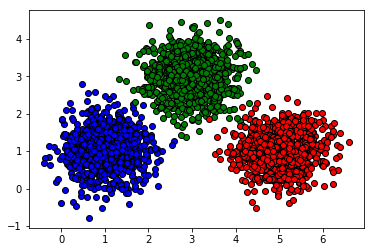

In [58]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

myPlotClustering(X, labels)

### Grupowanie za pomocą KMeans

In [59]:
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up co

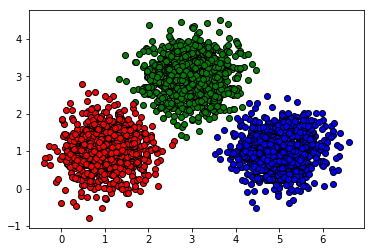

Silhouette Coefficient:  0.681685039267
Dunn index:  4.49994466065
Davies-Bouldin index:  0.436336794455


In [60]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

myPlotClustering(X, k_means.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))

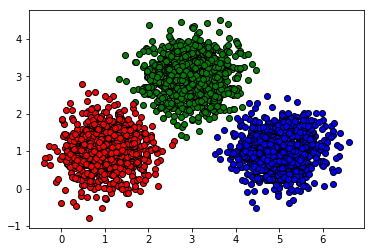

Silhouette Coefficient:  0.681685039267
Dunn index:  4.49994466065
Davies-Bouldin index:  0.436336794455


In [61]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=5)
k_means.fit(X)

myPlotClustering(X, k_means.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))

### Grupowanie za pomocą MiniBatchKMeans

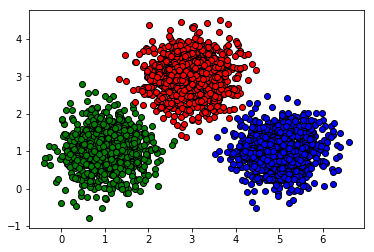

Silhouette Coefficient:  0.681685039267
Dunn index:  4.56159928266
Davies-Bouldin index:  0.433059168574


In [62]:
mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=1, max_no_improvement=10, verbose=0, random_state=0)
mini_batch_k_means.fit(X)

myPlotClustering(X, mini_batch_k_means.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, mini_batch_k_means.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, mini_batch_k_means.cluster_centers_.T, mini_batch_k_means.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, mini_batch_k_means.cluster_centers_.T, mini_batch_k_means.labels_))

### Grupowanie za pomocą Birch bez wtórnego grupowania

In [63]:
help(Birch)

Help on class Birch in module sklearn.cluster.birch:

class Birch(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, sklearn.base.ClusterMixin)
 |  Implements the Birch clustering algorithm.
 |  
 |  Every new sample is inserted into the root of the Clustering Feature
 |  Tree. It is then clubbed together with the subcluster that has the
 |  centroid closest to the new sample. This is done recursively till it
 |  ends up at the subcluster of the leaf of the tree has the closest centroid.
 |  
 |  Read more in the :ref:`User Guide <birch>`.
 |  
 |  Parameters
 |  ----------
 |  threshold : float, default 0.5
 |      The radius of the subcluster obtained by merging a new sample and the
 |      closest subcluster should be lesser than the threshold. Otherwise a new
 |      subcluster is started.
 |  
 |  branching_factor : int, default 50
 |      Maximum number of CF subclusters in each node. If a new samples enters
 |      such that the number of subclusters exceed the branching

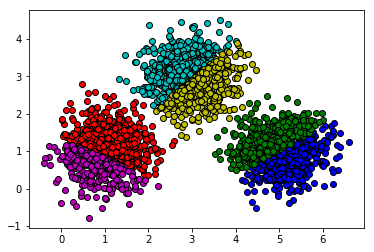

Silhouette Coefficient:  0.299573362816
Dunn index:  1.4615230783
Davies-Bouldin index:  1.29303249168


In [64]:
birch = Birch(threshold=0.75, n_clusters=None)
birch.fit(X)

myPlotClustering(X, birch.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, birch.root_.centroids_.T, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, birch.root_.centroids_.T, birch.labels_))

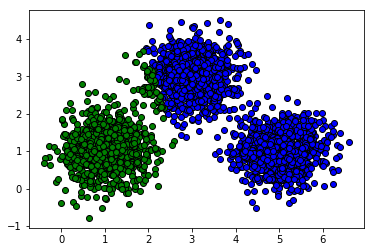

Silhouette Coefficient:  0.526047072879
Dunn index:  2.08458668866
Davies-Bouldin index:  0.699899385181


In [65]:
birch = Birch(threshold=2.0, n_clusters=None)
birch.fit(X)

myPlotClustering(X, birch.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, birch.root_.centroids_.T, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, birch.root_.centroids_.T, birch.labels_))

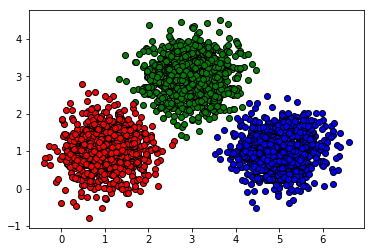

Silhouette Coefficient:  0.681685039267
Dunn index:  4.49994466065
Davies-Bouldin index:  0.436336794455


In [66]:
birch = Birch(threshold=1.0, n_clusters=None)
birch.fit(X)
myPlotClustering(X, birch.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, birch.root_.centroids_.T, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, birch.root_.centroids_.T, birch.labels_))

In [67]:
help(Birch)

Help on class Birch in module sklearn.cluster.birch:

class Birch(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, sklearn.base.ClusterMixin)
 |  Implements the Birch clustering algorithm.
 |  
 |  Every new sample is inserted into the root of the Clustering Feature
 |  Tree. It is then clubbed together with the subcluster that has the
 |  centroid closest to the new sample. This is done recursively till it
 |  ends up at the subcluster of the leaf of the tree has the closest centroid.
 |  
 |  Read more in the :ref:`User Guide <birch>`.
 |  
 |  Parameters
 |  ----------
 |  threshold : float, default 0.5
 |      The radius of the subcluster obtained by merging a new sample and the
 |      closest subcluster should be lesser than the threshold. Otherwise a new
 |      subcluster is started.
 |  
 |  branching_factor : int, default 50
 |      Maximum number of CF subclusters in each node. If a new samples enters
 |      such that the number of subclusters exceed the branching

### Grupowanie za pomocą Birch z wtórnym grupowaniem

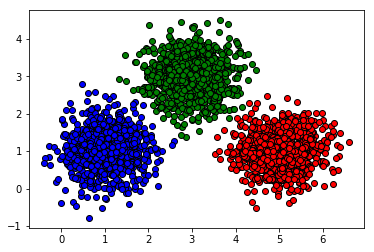

Silhouette Coefficient:  0.681598818652
Dunn index:  4.51102778427
Davies-Bouldin index:  0.436264235197


In [68]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)
myPlotClustering(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in range(np.unique(birch.labels_).shape[0]):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:602: UserWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters))


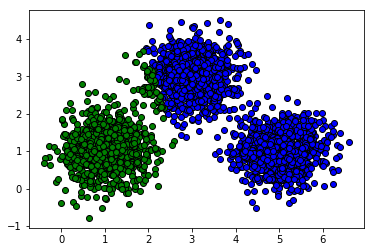

Silhouette Coefficient:  0.526047072879
Dunn index:  2.08583823469
Davies-Bouldin index:  0.699423009445


In [69]:
birch = Birch(threshold=2.0, n_clusters=3)
birch.fit(X)
myPlotClustering(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

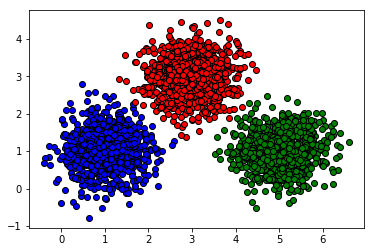

Silhouette Coefficient:  0.681685039267
Dunn index:  4.49994466065
Davies-Bouldin index:  0.436336794455


In [70]:
birch = Birch(threshold=1.0, n_clusters=3)
birch.fit(X)
myPlotClustering(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

### Grupowanie za pomocą DBScan

In [71]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster.dbscan_:

class DBSCAN(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, optional
 |      The maximum distance between two samples for them to be considered
 |      as in the same neighborhood.
 |  
 |  min_samples : int, optional
 |      The number of samples (or total weight) in a neighborhood for a point
 |      to be considered as a core point. This includes the point itself.
 |  
 |  metric : string, or callable
 |      The metric to use when calculating distance between instances in a
 |      feature array. If metric is a string or callable, it must 

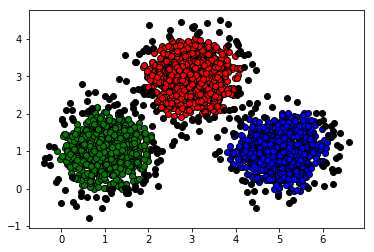

Silhouette Coefficient:  0.612610705825
Dunn index:  4.95841679121
Davies-Bouldin index:  0.396503918008


In [72]:
dbscan = DBSCAN(eps=0.25, min_samples=25)
dbscan.fit(X)

myPlotClustering(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))

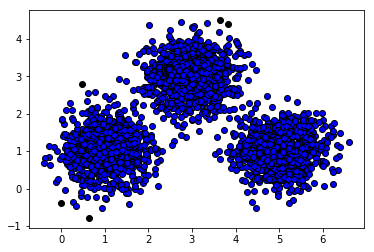

Silhouette Coefficient:  0.255082901388
Dunn index:  0.0


In [73]:
dbscan = DBSCAN(eps=0.5, min_samples=25)
dbscan.fit(X)

myPlotClustering(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
# print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))

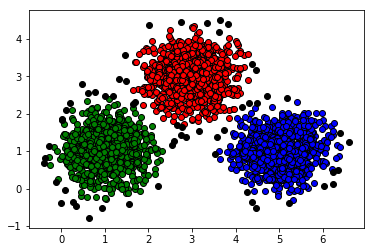

Silhouette Coefficient:  0.66147316903
Dunn index:  4.6144003154
Davies-Bouldin index:  0.424100062787


In [74]:
dbscan = DBSCAN(eps=0.35, min_samples=25)
dbscan.fit(X)

myPlotClustering(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))

## 2. Drugi zestaw danych
Dane IRIS

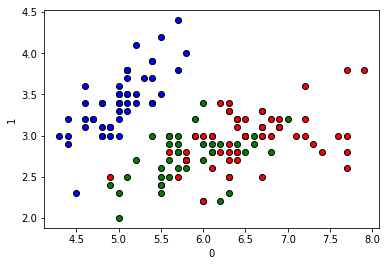

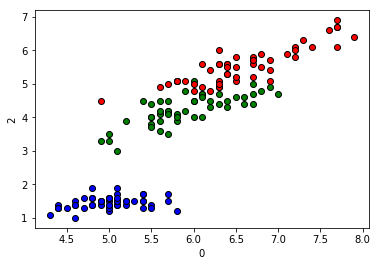

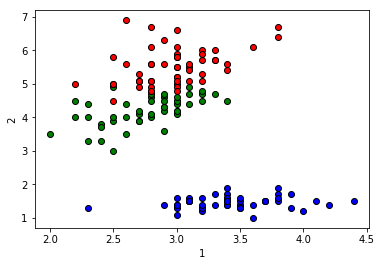

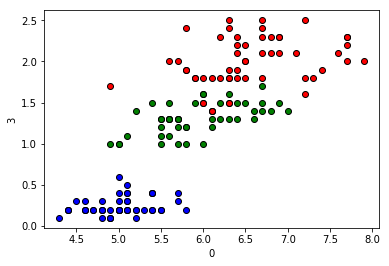

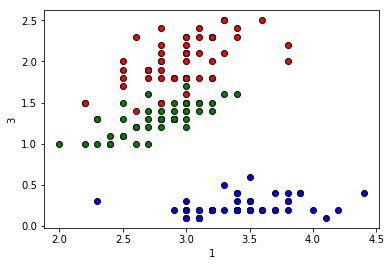

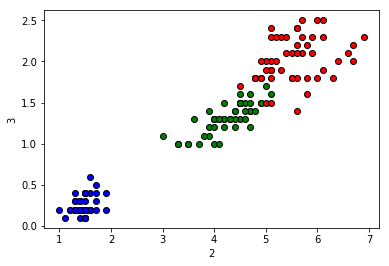

In [75]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
myPlot(X, iris.target)

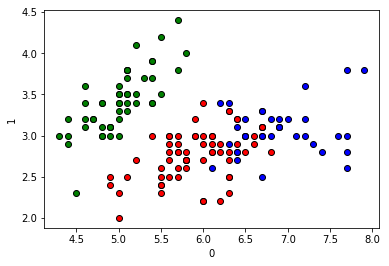

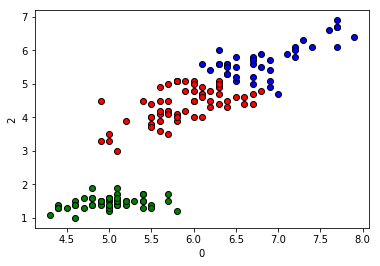

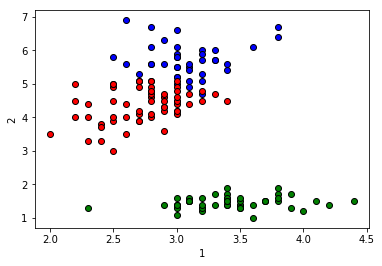

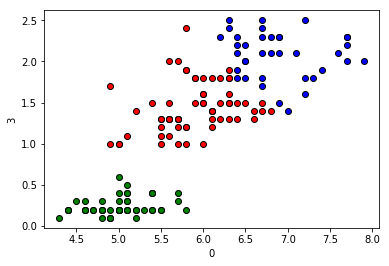

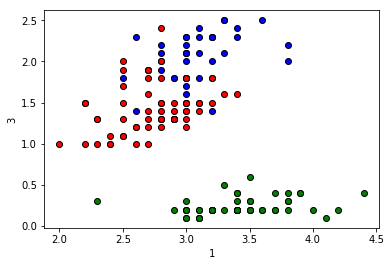

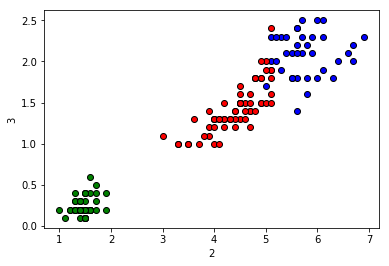

Silhouette Coefficient:  0.550964374652
Dunn index:  2.44371608361
Davies-Bouldin index:  0.66639121071


In [76]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)
myPlot(X, k_means.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))

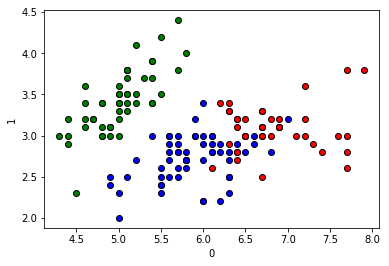

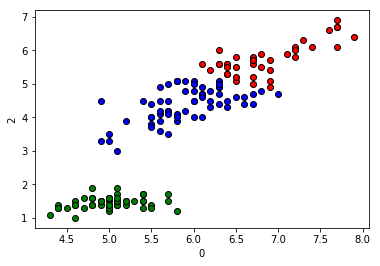

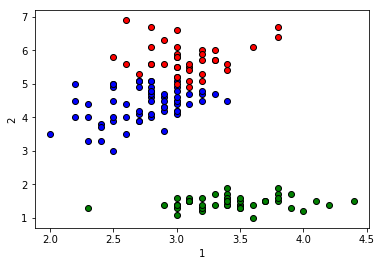

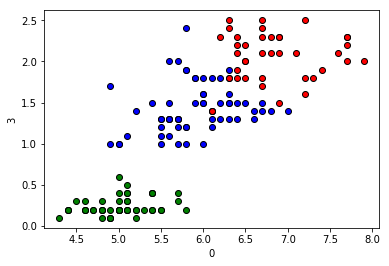

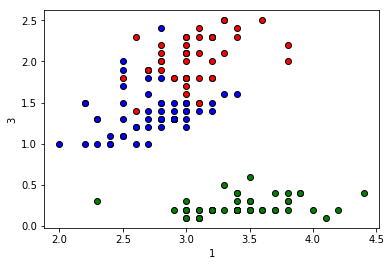

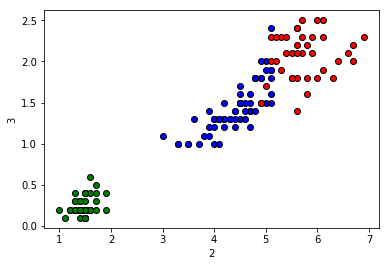

Silhouette Coefficient:  0.552591944531
Dunn index:  2.43470301486
Davies-Bouldin index:  0.66232286499


In [77]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=3)
k_means.fit(X)
myPlot(X, k_means.labels_)
print('Silhouette Coefficient: ',metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, k_means.cluster_centers_.T, k_means.labels_))

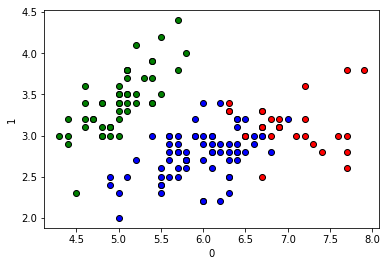

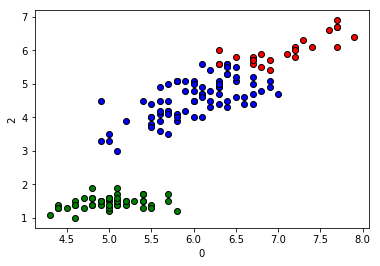

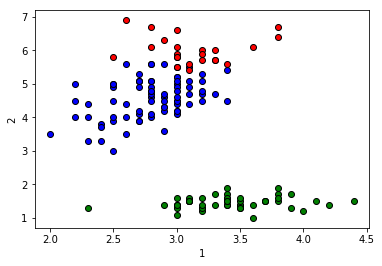

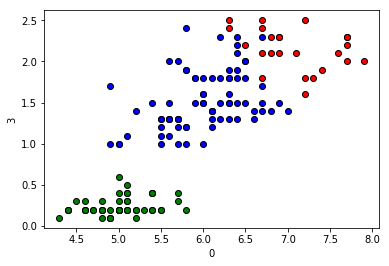

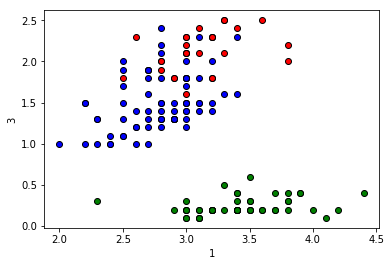

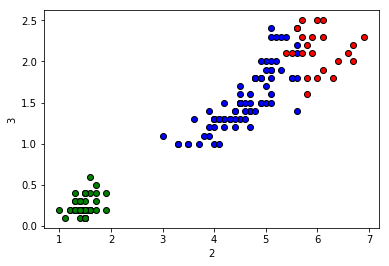

Silhouette Coefficient:  0.535269177612
Dunn index:  2.34147394745
Davies-Bouldin index:  0.645717744322


In [78]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

myPlot(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

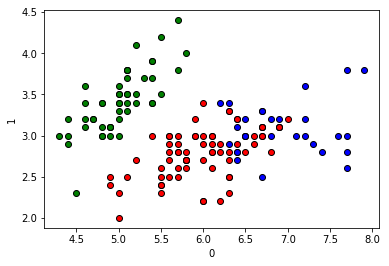

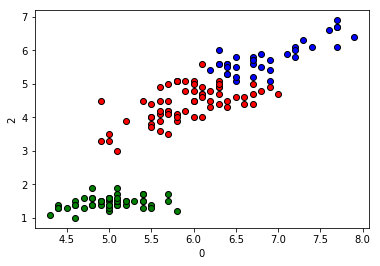

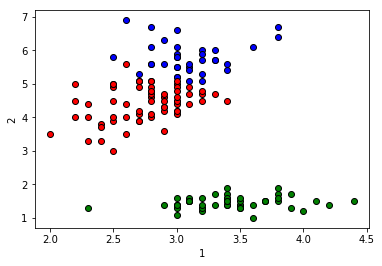

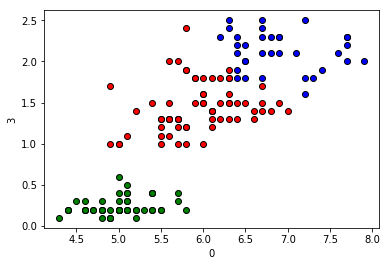

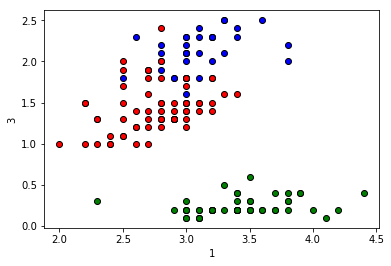

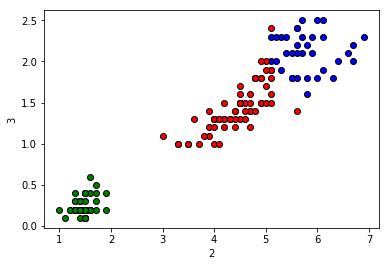

Silhouette Coefficient:  0.555080215256
Dunn index:  2.41324808313
Davies-Bouldin index:  0.654205942164


In [79]:
birch = Birch(threshold=1.0, n_clusters=3)
birch.fit(X)

myPlot(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

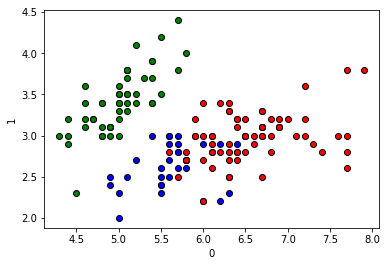

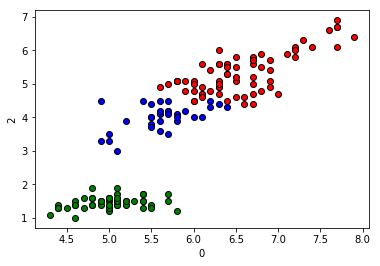

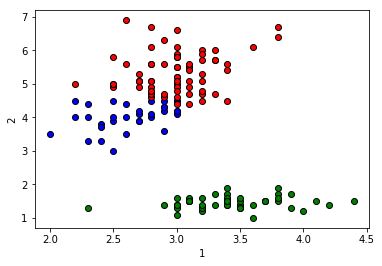

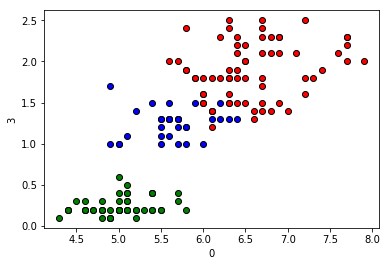

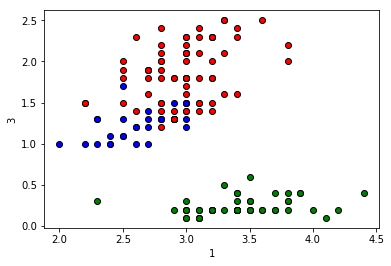

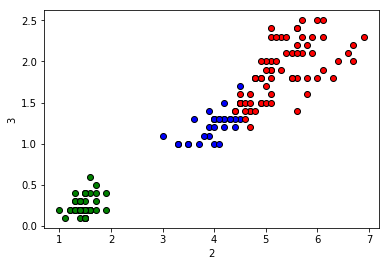

Silhouette Coefficient:  0.518437506801
Dunn index:  2.10330123932
Davies-Bouldin index:  0.650893199422


In [80]:
birch = Birch(threshold=1.25, n_clusters=3)
birch.fit(X)

myPlot(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

/home/dominik/anaconda3/lib/python3.6/site-packages/sklearn/cluster/birch.py:602: UserWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters))


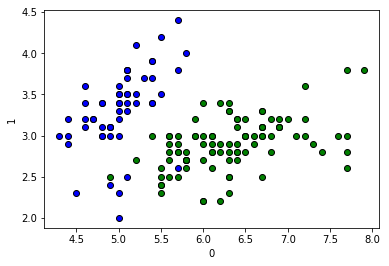

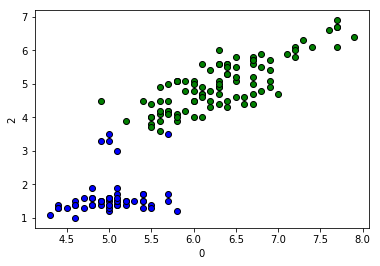

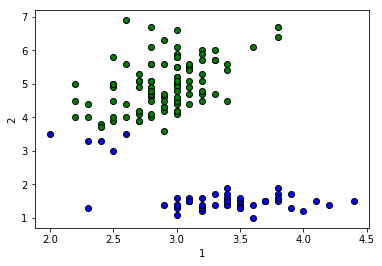

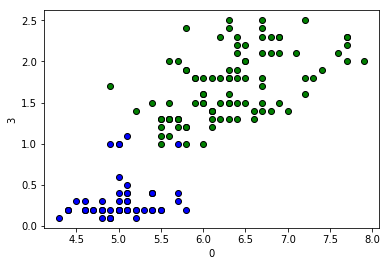

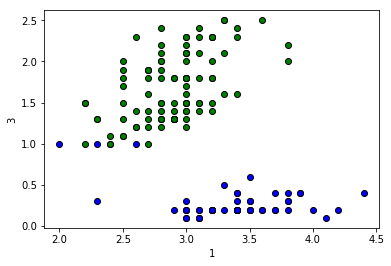

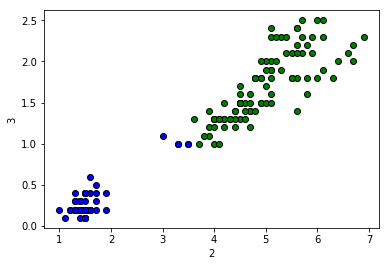

Silhouette Coefficient:  0.670689041945
Dunn index:  3.94636847416
Davies-Bouldin index:  0.425651339106


In [81]:
birch = Birch(threshold=1.5, n_clusters=3)
birch.fit(X)

myPlot(X, birch.labels_)
centers = np.empty((X.shape[1],np.unique(birch.labels_).shape[0]))
for i in np.unique(birch.labels_):
    l = X.T[:,birch.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, birch.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, birch.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, birch.labels_))

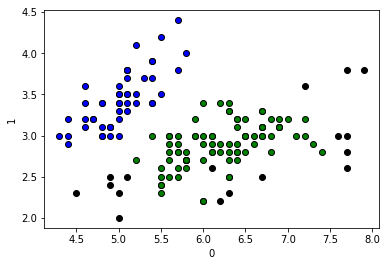

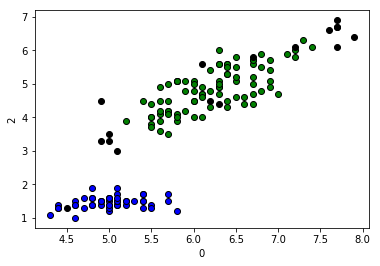

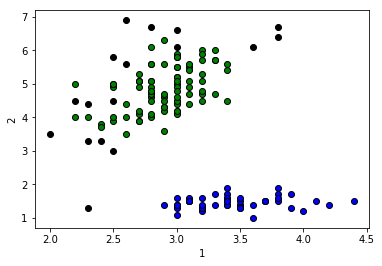

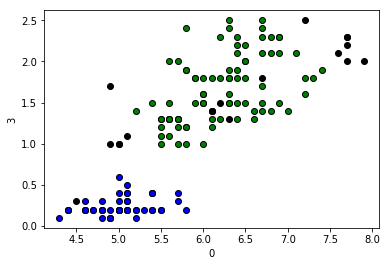

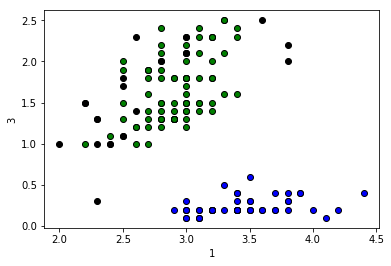

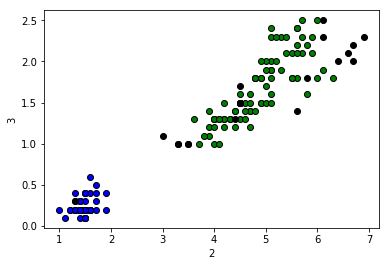

Silhouette Coefficient:  0.485842354584
Dunn index:  4.44572361031
Davies-Bouldin index:  0.345230751555


In [82]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

myPlot(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))

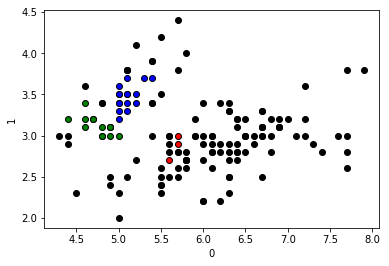

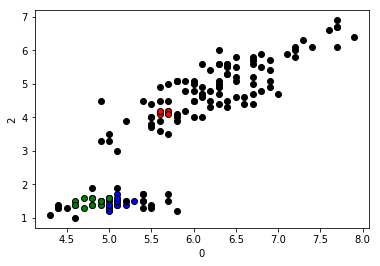

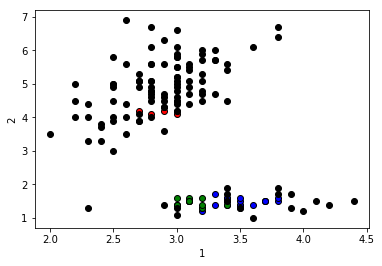

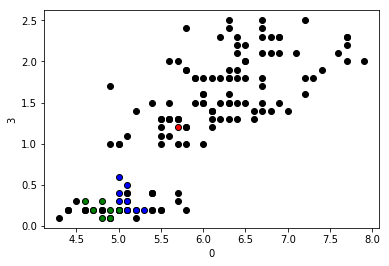

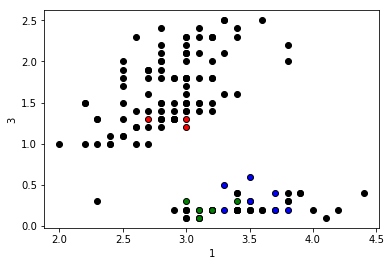

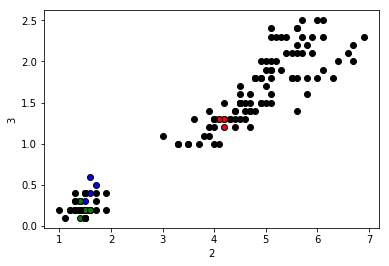

Silhouette Coefficient:  -0.150885799241
Dunn index:  2.08045348559
Davies-Bouldin index:  0.639204073094


In [83]:
dbscan = DBSCAN(eps=0.25, min_samples=5)
dbscan.fit(X)
myPlot(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))

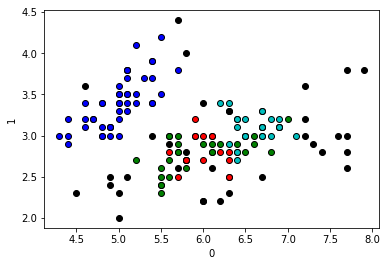

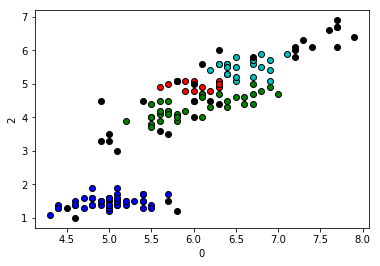

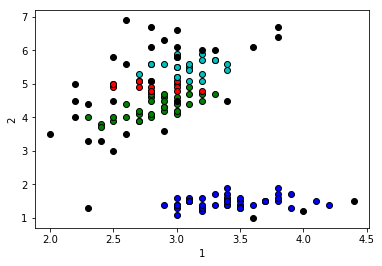

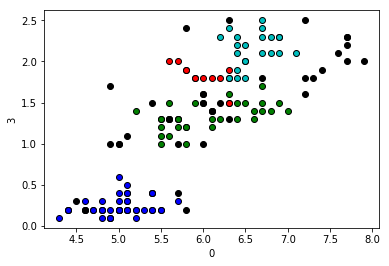

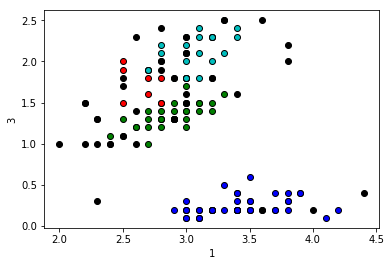

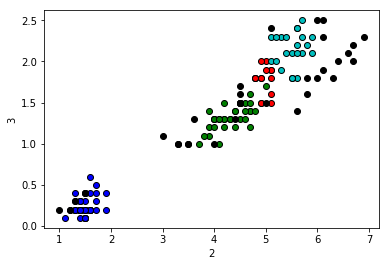

Silhouette Coefficient:  0.277822654436
Dunn index:  1.30018357916
Davies-Bouldin index:  0.897467876894


In [84]:
dbscan = DBSCAN(eps=0.4, min_samples=5)
dbscan.fit(X)

myPlot(X, dbscan.labels_)
centers = np.empty((X.shape[1],np.unique(dbscan.labels_).shape[0] -1))
for i in range(np.unique(dbscan.labels_).shape[0] -1):
    l = X.T[:,dbscan.labels_ == i]
    centers[:,i] = np.sum(l, axis=1)/l.shape[1]
print('Silhouette Coefficient: ',metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
print('Dunn index: ', dunnIndex(X.T, centers, dbscan.labels_))
print('Davies-Bouldin index: ', daviesBouldinIndex(X.T, centers, dbscan.labels_))